
# Command-Measure Test

Here commands can be sent to the NODEMCU and data is retrieved with the arduino. Afterwards data can be easily analyzed in python, which enables an efficient platform for quick tests.

## Command Measure Code

In [5]:
# From https://www.learnrobotics.org/blog/arduino-data-logger-csv/
import serial
import csv
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import seaborn as sns

In [6]:
# Connect to arduino for measurements and serial communication
arduino_port = "/dev/ttyACM0" #serial port of Arduino, sometimes ACM1.. no idea why
baud = 9600 #arduino uno runs at 9600 baud
ser = serial.Serial(arduino_port, baud)
print("Connected to Arduino port:" + arduino_port)

Connected to Arduino port:/dev/ttyACM0


In [10]:
# Send command as GET with data to send between $'data'$.
frequence = 5
amplitude = 65 # with this amplitude we get a real amplitude close to 40° which is what we are looking for

print("Sending command ...")
html = urllib.request.urlopen(f"http://192.168.43.246/${frequence},{amplitude}$")
print("Sent!")

# Command arduino to start measuring
print("Reading sensor...")
ser.write('t'.encode())
getData=ser.readline()
print("Read!")

# Read line that arduino printed in serial port
dataString = getData.decode('utf-8')
# Convert Serial line to array
array = np.fromstring(dataString[:-3], dtype=float, sep=',').reshape((-1,3))
array = np.unique(array, axis=0)

Sending command ...
Sent!
Reading sensor...
Read!


## Analysis
From here the different Analysis from the obtained data can be made.

### Servo max frequency-amplitud
**Goal:** to find out maximal realistic frequency of servo at a 40° total amplitude. Ideally somewhere between 5-8Hz.

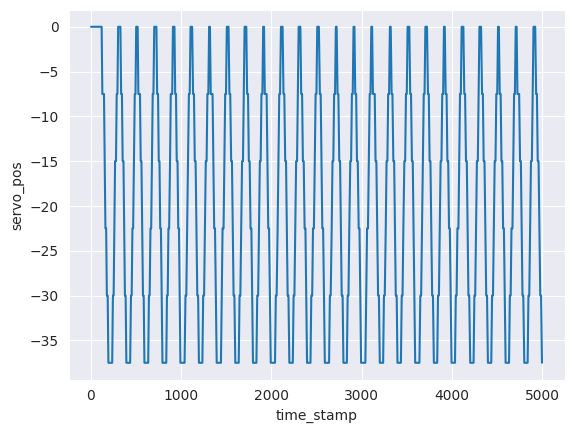

In [11]:
# Get Data: A and B are value from A and B hall sensors
df = pd.DataFrame(array, columns=['time_stamp', 'A', 'B'])
def map_tocount(row):
    if row['A'] == 0 and row['B'] == 0:
        return 0
    elif row['A'] == 1 and row['B'] == 0:
        return 1
    elif row['A'] == 1 and row['B'] == 1:
        return 2
    elif row['A'] == 0 and row['B'] == 1:
        return 3
    else:
        return np.nan
# Decode binary code in count within a period.

df['count'] = df.apply(map_tocount, axis=1)
# Calculate when a count (min perceived angle change) happened, in which direction and multiply with angle.
angle_0 = 360/(12*4) # 12 periods in a turn, 4 counts per period. 360° divided by total counts = angle_0/count.
diff = df['count'].diff().replace([-3, 3], [1, -1])*angle_0

# Cumulative of diff gives servo position
servo_pos = diff.cumsum()

df['servo_pos'] = servo_pos
sns.lineplot(df, x='time_stamp', y='servo_pos')
plt.show()

In [116]:
df[118:128]['servo_pos']

118     0.0
119    -7.5
120    -7.5
121    -7.5
122   -15.0
123   -22.5
124   -22.5
125   -30.0
126   -30.0
127   -37.5
Name: servo_pos, dtype: float64

In [117]:
# Calculate omega
np.polyfit(df[118:128]['time_stamp'], df[118:128]['servo_pos'], 1)

array([ -0.4669923 , 443.20159858])

From the calculated omega, we can theoretically find the highest frequency possible for an amplitude of 40 degrees.

In [4]:
omega = 0.46 # Angles per millisecond

half_period = 40/omega
max_frequency = 1000/(2*half_period)
max_frequency

5.75

### Prototype calculations

In [12]:
def min_max_creator(min=210, max=970):
    return lambda x: (2 / (max-min)) * x + 1 - 2 * max / (max-min)


min_max = min_max_creator()
array[:,1] = min_max(array[:,1])

(-1.0, 1.0)

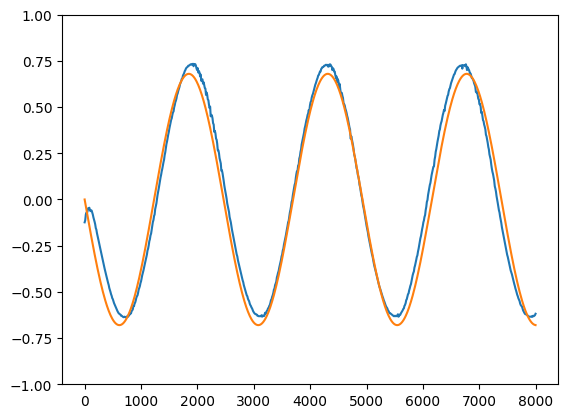

In [14]:
soll = lambda x: -0.68 * np.sin(0.00255* x)
plt.plot(array[:, 0], array[:, 1])
plt.plot(array[:, 0], soll(array[:, 0]))
plt.ylim((-1,1))


(-1.0, 1.0)

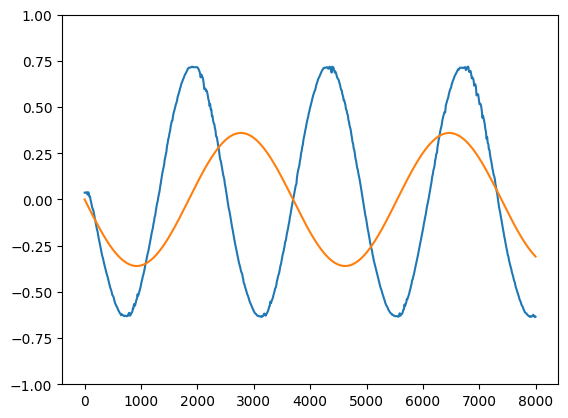

In [48]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, array[:, 0], array[:, 1])

print(params)